<a href="https://colab.research.google.com/github/sreekanth0555/fmml/blob/main/tomato_pest_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks

Project:Write an Algorithm for a Tomato plant to Predict the Disease.

we can see that the development was taking place in all aspects where as in the agriculture we didn't find that much improvement in the technology.In this notebook we would like to write an algorithm to detect the disease of a plant.It  also displays above the image the confidence as the accuracy of that disease in percentage and also shows us the name of that perticular disease.

With the help of CNN we will predict the disease of that plant  the future scope for  this we can make a app for the detection  of that disease.


step 1: Import libraries and Datasets


step 2: Building the Model

step 3: Data Augmentation

step 4: Model architecture

Step 5: Compiling the Model

step 6: Plotting the Accuracy and Loss Curves

Step 7: Run prediction on a sample image 

step 8: Save the model
    


Step 1: import libraries and Datasets

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

assign all the Constants

In [ ]:
BATCH_SIZE = 50
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=10

Import all the data into tensorflow dataset object and assign the constants 

In [ ]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "plant_ds",
    seed=24,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [ ]:
class_name = dataset.class_names
class_name

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(50, 256, 256, 3)
[5 2 2 5 7 3 2 9 9 7 3 6 3 7 2 4 3 5 1 0 0 6 3 7 1 2 4 3 6 0 9 5 5 4 7 6 7
 3 0 7 9 9 0 7 9 7 7 7 7 7]


Visualize some of the images from our dataset

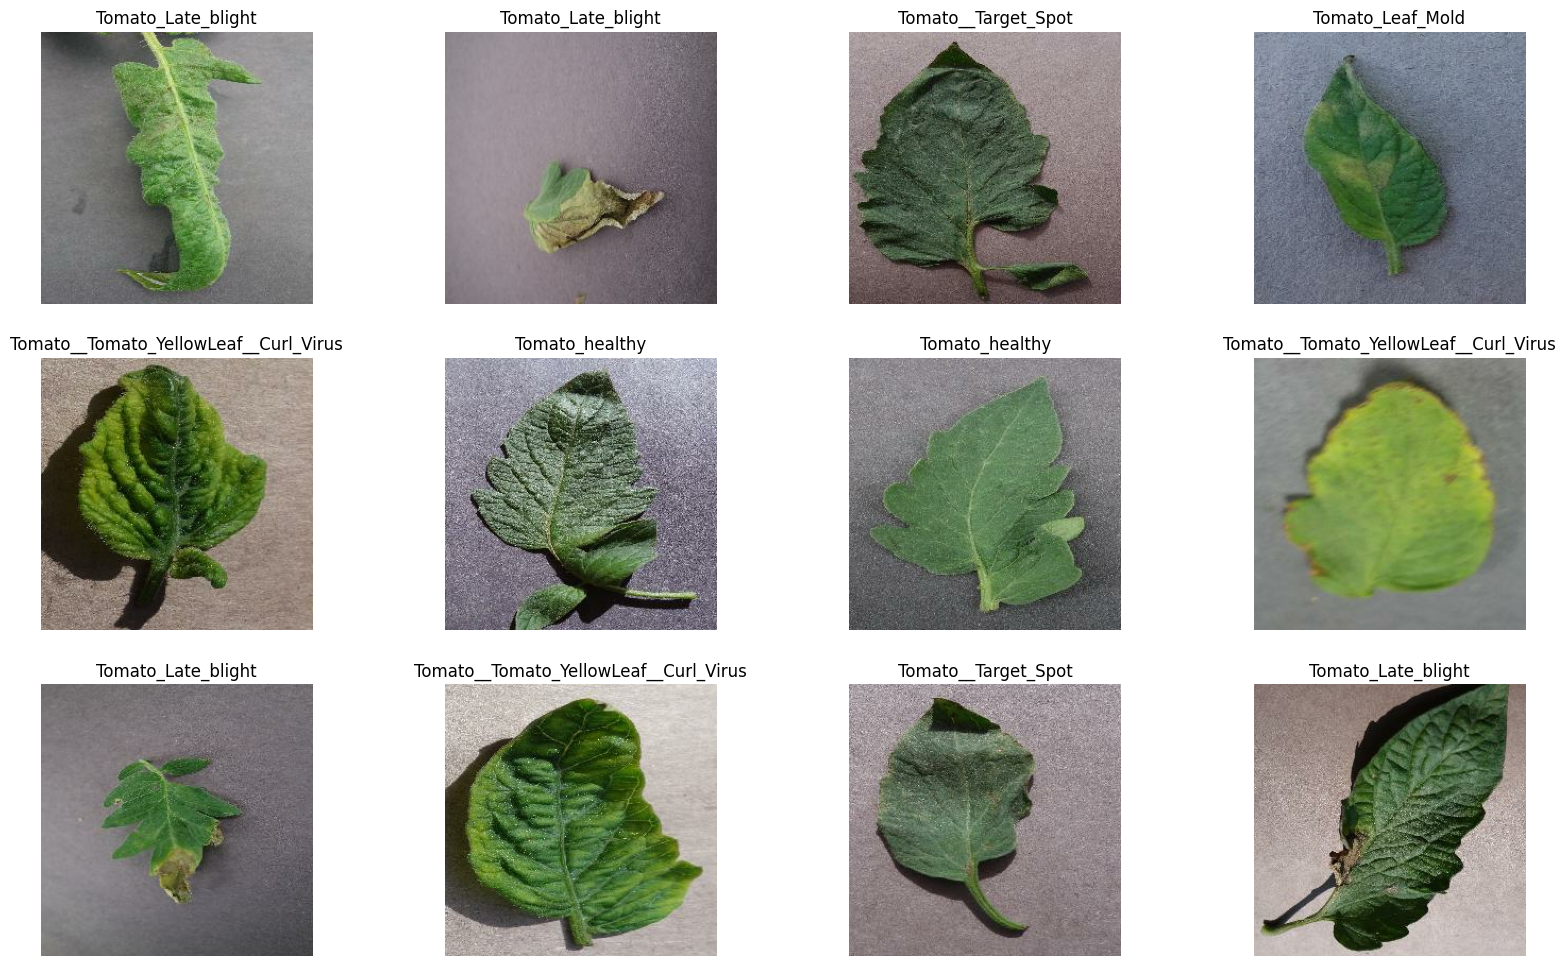

In [ ]:
plt.figure(figsize=(20, 12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[labels_batch[i]])
        plt.axis("off")

Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:

1.Training: Dataset to be used while training

2.Validation: Dataset to be tested against while training

3.Test: Dataset to be tested against after we trained a model


In [ ]:
len(dataset)


321

In [ ]:
train_size = 0.8
len(dataset)*train_size

256.8

In [ ]:
train_ds=dataset.take(256)
len(train_ds)

256

In [ ]:
test_ds = dataset.skip(25)
len(test_ds)

65

In [ ]:
val_size=0.1
len(dataset)*val_size

32.1

In [ ]:
val_ds = test_ds.take(32)
len(val_ds)

32

In [ ]:
test_ds = test_ds.skip(32)
len(test_ds)

33

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

256

In [ ]:
len(val_ds)

32

In [ ]:
len(test_ds)

33

Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

step 2: Building the Model

Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./256),
])

step 3:Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

Applying Data Augmentation to Train Dataset

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
    ).prefetch(buffer_size=tf.data.AUTOTUNE)

step 4: Model architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(30, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (50, 256, 256, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (50, 254, 254, 30)        840       
                                                                 
 max_pooling2d_18 (MaxPoolin  (50, 127, 127, 30)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (50, 125, 125, 64)        17344     
                                                                 
 max_pooling2d_19 (MaxPoolin  (50, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (50, 60, 60, 64)         

Step 5: Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
256/256 [==============================] - 277s 1s/step - loss: 0.6239 - accuracy: 0.7774 - val_loss: 2.0361 - val_accuracy: 0.5619
Epoch 2/10
256/256 [==============================] - 287s 1s/step - loss: 0.5199 - accuracy: 0.8133 - val_loss: 0.7938 - val_accuracy: 0.7519
Epoch 3/10
256/256 [==============================] - 289s 1s/step - loss: 0.4371 - accuracy: 0.8459 - val_loss: 1.2714 - val_accuracy: 0.7044
Epoch 4/10
256/256 [==============================] - 289s 1s/step - loss: 0.3468 - accuracy: 0.8753 - val_loss: 2.1026 - val_accuracy: 0.6087
Epoch 5/10
256/256 [==============================] - 301s 1s/step - loss: 0.3228 - accuracy: 0.8868 - val_loss: 0.9312 - val_accuracy: 0.7450
Epoch 6/10
256/256 [==============================] - 533s 2s/step - loss: 0.2746 - accuracy: 0.9035 - val_loss: 0.7081 - val_accuracy: 0.7931
Epoch 7/10
256/256 [==============================] - 286s 1s/step - loss: 0.2614 - accuracy: 0.9102 - val_loss: 0.8609 - val_accuracy: 0.7831

In [ ]:
scores = model.evaluate(test_ds)

33/33 [==============================] - 12s 348ms/step - loss: 0.5400 - accuracy: 0.8503


In [ ]:
scores

[0.540009081363678, 0.850303053855896]

step 6: Plotting the Accuracy and Loss Curves


In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 256}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
type(history.history['loss'])
len(history.history['loss'])

10

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.6238595843315125,
 0.5199397802352905,
 0.4371004104614258,
 0.34684696793556213,
 0.32281559705734253]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

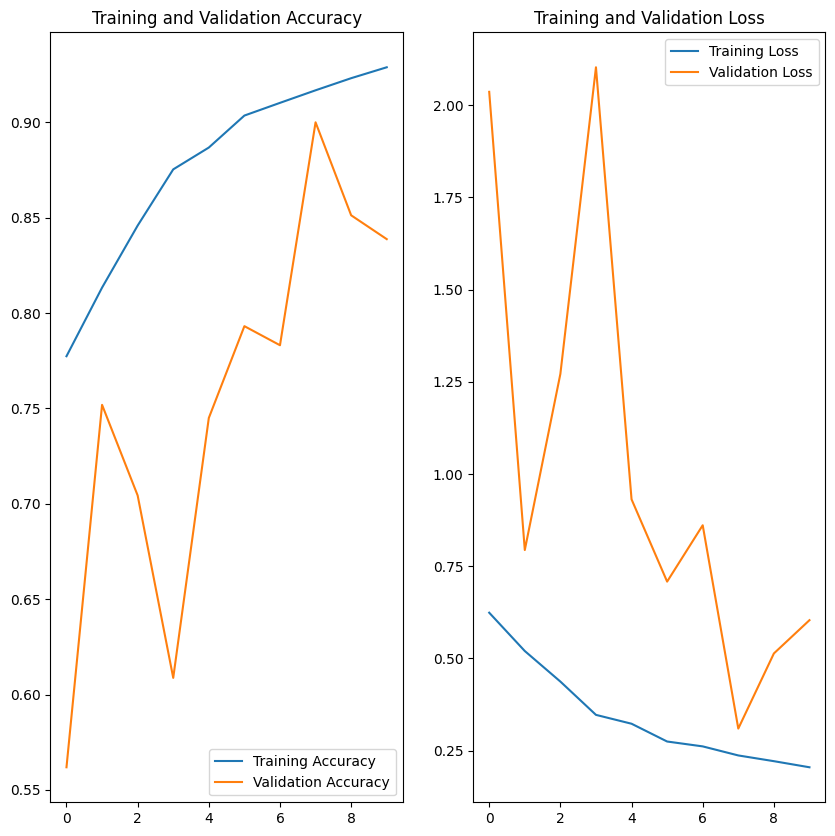

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Step 7: Run prediction on a sample image

first image to predict
actual label: Tomato__Tomato_YellowLeaf__Curl_Virus
2/2 [==============================] - 0s 99ms/step
predicted label: Tomato__Tomato_YellowLeaf__Curl_Virus


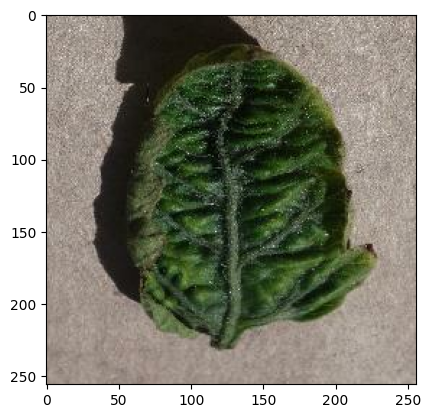

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

In [ ]:
#Write a function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run inference on few sample images and see the acuuracy

1/1 [==============================] - 0s 14ms/step


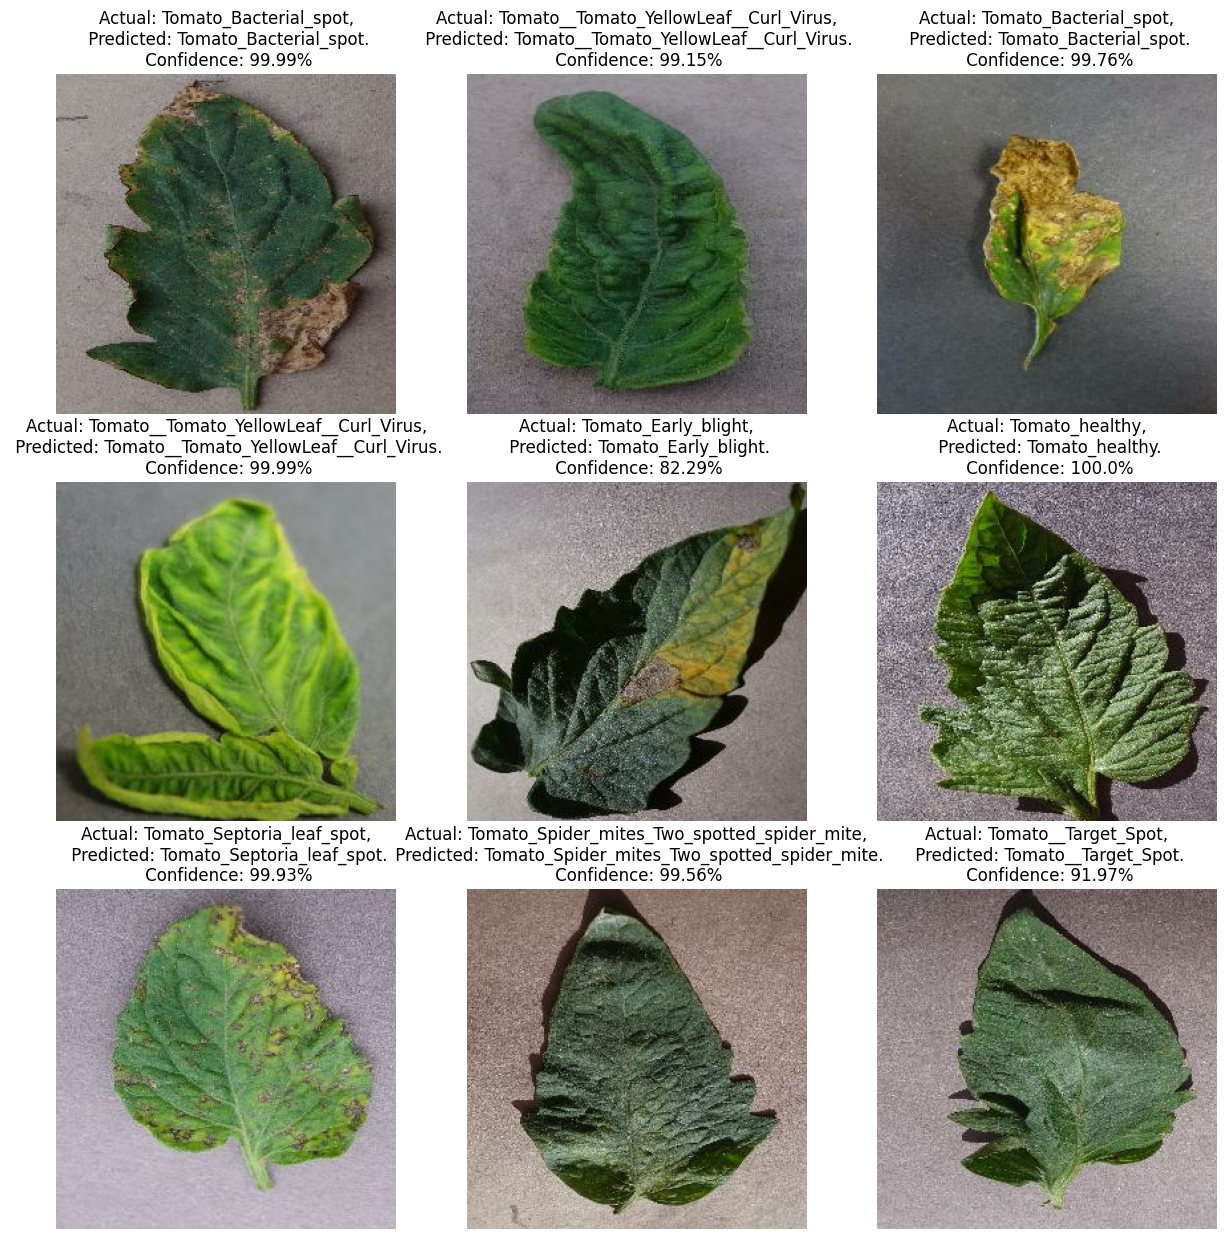

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Saving the Model

We append the model to the list of models as a new version



In [ ]:
import os
model_version=2
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2/assets


INFO:tensorflow:Assets written to: ../models/2/assets


In [ ]:
model.save("../tomato.h5")